In [322]:
import os
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Ensure the plots directory exists
os.makedirs('plots', exist_ok=True)

def baselauncher(A, B, C, return_trajectory=False):
    """
    Compute launch speed and angle given settings.
    A: fine height setting (1–5)
    B: main height setting (0–6, inverted internally)
    C: power setting (1–11)
    return_trajectory: bool, if True returns extra trajectory data.
    Returns: dict with keys 'speed', 'angle', and optionally 'time', 'theta', 'r', 'v_abs', 'normalkraft'.
    """
    # Validate inputs
    if not (1 <= A <= 5):
        raise ValueError("Parameter A (fine height) must be in range 1–5")
    if not (0 <= B <= 6):
        raise ValueError("Parameter B (main height) must be in range 0–6")
    if not (1 <= C <= 11):
        raise ValueError("Parameter C (power) must be in range 1–11")

    # Map user inputs to indices
    height_fine = A - 1
    height_main = 6 - B
    power_setting = C - 1

    # Geometry constants
    AO, CO, DO, AE_L0 = 0.125, 0.360, 0.440, 0.280

    # Settings arrays
    DE = np.arange(11) * 0.0235 + 0.039
    theta_rad_initial = np.deg2rad([5.8, 9.7, 13.7, 17.7, 21.8, 26, 30.2])
    BO_initial = [0.123, 0.143, 0.163, 0.183, 0.203]

    # Ball and arm parameters
    r_ball, m_ball = 0.074/2, 0.145
    I_ball = 2/5 * m_ball * r_ball**2
    I_AC = 0.059
    k = 3212

    # Define ODE system
    def system(t, y):
        theta, theta_dot, r, r_dot = y
        # spring extension
        spring_ext = (np.sqrt((DE[power_setting] - AO*np.cos(theta))**2 +
                              (-DO + AO*np.sin(theta))**2) - AE_L0)
        phi = np.arctan2(-DO + AO*np.sin(theta), DE[power_setting] - AO*np.cos(theta))
        theta_ddot = ((spring_ext * k * np.sin(theta-phi) * AO) - (r**2) * m_ball * 2 * theta_dot) \
                     / (I_AC + (r**2) * m_ball)
        rolling_loss = m_ball/(m_ball + I_ball/0.030**2)
        r_ddot = rolling_loss * theta_dot**2 * r
        return [theta_dot, theta_ddot, r_dot, r_ddot]

    # Event: ball leaves launcher
    def event_leave(t, y): return y[2] - CO
    event_leave.terminal = True; event_leave.direction = 1

    # Initial conditions and solve
    y0 = [theta_rad_initial[height_main], 0.0, BO_initial[height_fine], 0.0]
    sol = solve_ivp(system, (0,0.5), y0, events=event_leave,
                    t_eval=np.linspace(0,0.5,100000), dense_output=True)

    # Extract kinematics
    theta, theta_dot, r, r_dot = sol.y
    v_abs = np.hypot(theta_dot * r, r_dot)
    v_dir_DE = np.arctan2(theta_dot * r, r_dot) + theta

    speed = v_abs[-1]
    launch_angle = np.rad2deg(np.pi - v_dir_DE[-1]) + 3.2

    result = {'speed': speed, 'angle': launch_angle}
    if return_trajectory:
        theta_ddot_vals = [system(t, sol.y[:,i])[1] for i, t in enumerate(sol.t)]
        normalkraft = m_ball * (2 * theta_dot + theta_ddot_vals) * r
        result.update({'time': sol.t, 'theta': theta, 'r': r,
                       'v_abs': v_abs, 'normalkraft': normalkraft})
    return result


def plot_trajectory(A, B, C, polar=True, save=False):
    """
    Plot the launch trajectory for given settings.
    A: fine height, B: main height, C: power.
    polar: bool for polar vs Cartesian.
    save: bool to save plot as 'plots/bane-A-B-C.png'.
    """
    data = baselauncher(A, B, C, return_trajectory=True)
    theta, r = data['theta'], data['r']
    speed, angle = data['speed'], data['angle']

    fig, ax = plt.subplots(subplot_kw={'projection':'polar'} if polar else {})
    if polar:
        ax.plot(theta, r, label=f'A={A}, B={B}, C={C}')
        ax.scatter(theta[-1], r[-1], c='red')
        ax.annotate(f"v={speed:.2f} m/s\nθ_launch={angle:.1f}°",
                    xy=(theta[-1], r[-1]),
                    xytext=(theta[-1]+0.2, max(r)*0.8),
                    arrowprops=dict(arrowstyle='->'))
        ax.set_xlabel('θ (rad)'); ax.set_ylabel('r (m)')
    else:
        x, y = r * np.cos(theta), r * np.sin(theta)
        ax.plot(x, y, label=f'A={A}, B={B}, C={C}')
        ax.scatter(x[-1], y[-1], c='red')
        ang_rad = np.deg2rad(angle)
        dx, dy = max(r)*0.1*np.cos(ang_rad), max(r)*0.1*np.sin(ang_rad)
        ax.arrow(x[-1], y[-1], dx, dy,
                 head_width=0.02, head_length=0.04,
                 length_includes_head=True)
        ax.annotate(f"v={speed:.2f} m/s, θ_launch={angle:.1f}°",
                    xy=(x[-1]+dx, y[-1]+dy),
                    xytext=(x[-1]+dx+0.05, y[-1]+dy+0.05),
                    arrowprops=dict(arrowstyle='->'))
        ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)'); ax.set_aspect('equal')

    ax.set_title('Ballbane på utkasteren')
    ax.legend()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

    if save:
        filename = f"plots/bane-{A}-{B}-{C}.png"
        fig.savefig(filename, bbox_inches='tight')
        print(f"Figure saved as {filename}")

    plt.show()


def interactive_launcher():
    # A: fine height (1-5), B: main height (0-6), C: power (1-11)
    A_slider = widgets.IntSlider(value=3, min=1, max=5, step=1, description='Fine height')
    B_slider = widgets.IntSlider(value=3, min=0, max=6, step=1, description='Main height')
    C_slider = widgets.IntSlider(value=6, min=1, max=11, step=1, description='Power')
    coord_toggle = widgets.ToggleButtons(
        options=[('Polar', True), ('Cartesian', False)],
        value=True,
        description='Coords'
    )
    save_chk = widgets.Checkbox(value=False, description='Save Plot')
    ui = widgets.VBox([A_slider, B_slider, C_slider, coord_toggle, save_chk])
    out = widgets.interactive_output(
        plot_trajectory,
        {'A': A_slider, 'B': B_slider, 'C': C_slider,
         'polar': coord_toggle, 'save': save_chk}
    )
    display(ui, out)


In [324]:
baselauncher(3,3,11)

{'speed': 20.470515162861123, 'angle': -12.420162769181044}

Figure saved as plots/bane-3-3-11.png


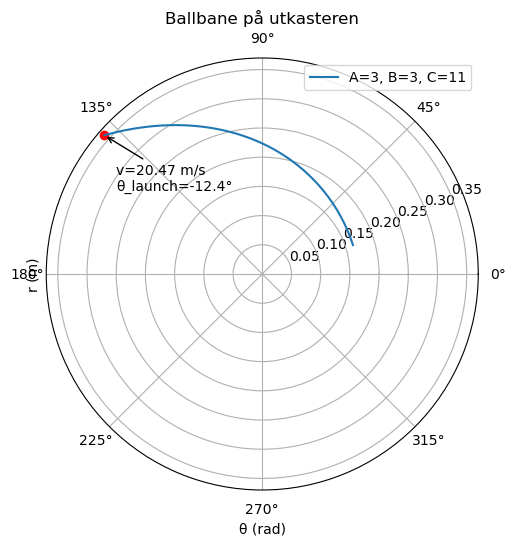

Figure saved as plots/bane-3-3-1.png


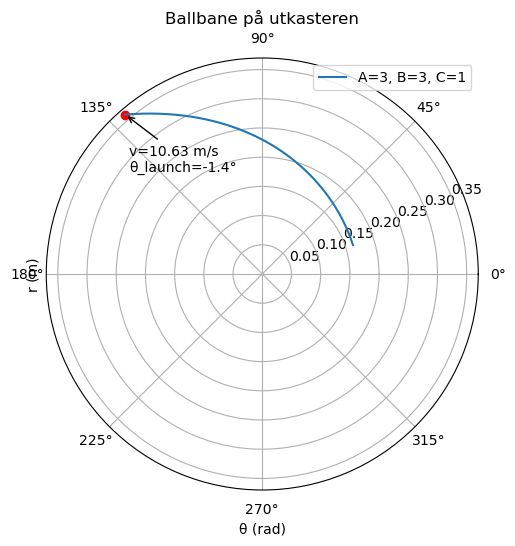

Figure saved as plots/bane-1-0-11.png


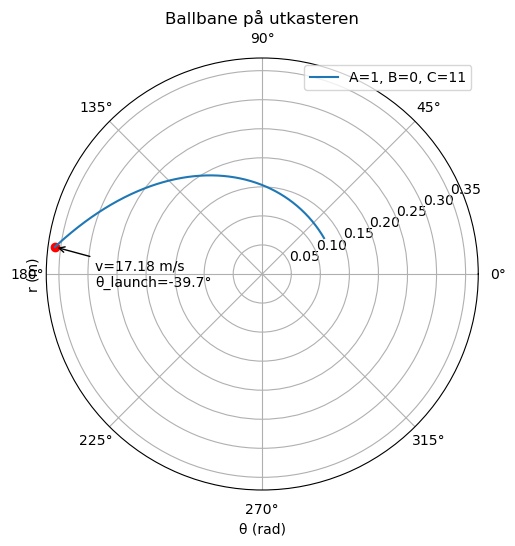

Figure saved as plots/bane-5-6-11.png


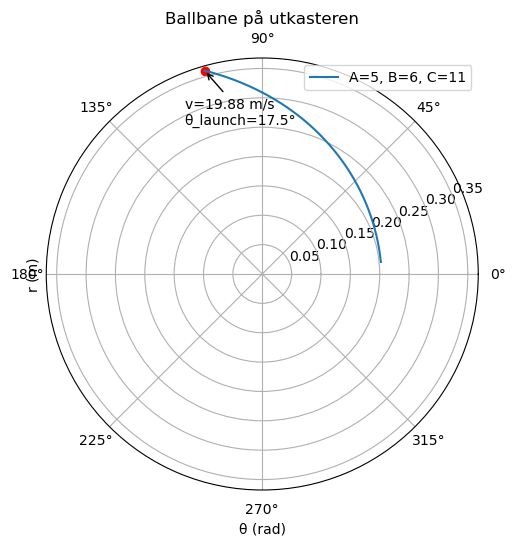

In [326]:
plot_trajectory(3,3,11, save=True)
plot_trajectory(3,3,1, save=True)#maks 11,6,5, minimum 1,0,1
plot_trajectory(1,0,11, save=True)
plot_trajectory(5,6,11, save=True)
